# Statistical Analysis Of Financial Data - Project Part 2 - COBRA Ensembles
## *Mriganka Basu Roy Chowdhury (Group 3) - 170123038*

$\newcommand{\R}{\mathbb{R}}\newcommand{\eps}{\epsilon}\newcommand{\a}{\alpha}\newcommand{\test}{\mathtt{test}}\newcommand{\train}{\mathtt{train}}\newcommand{\ind}{\mathbf{1}}$

In this second part of the project, we implement the COBRA Ensembling strategy. The main paper we reference is [1]. The setup is as follows:

1. There is a training dataset $(X_i, y_i) \in \R^{d + 1}$ of size $N$.  
2. We also have $M$ weak learners, $r_1 (\cdot), r_2 (\cdot), \ldots, r_M(\cdot) : \R^d \to \R$. Our range is $\R$ since we work on regression.

The goal is to "ensemble" these learners to form a combined regressor $r^{*}(\cdot)$ which is hopefully better than all these learners and in some sense, combines the strengths of these estimators. COBRA is one such strategy.

COBRA works as follows. We fix two hyperparameters $\eps > 0, \a \in \{1/M, 2/M, \ldots, 1\}$, and perform the following steps:

1. Split the dataset into two parts of size $k$ and $\ell = N - k$ respectively, and call then $\train$ containing datapoints with indices $1 \ldots k$, and $\test$ containing indices $k + 1 \ldots N$. We renumber these datapoints from $1 \ldots \ell$.

2. We train the weak learners $r_i$ on the $\train$ data.

3. Now, given any datapoint $X$, we first find the predictions $r_i(X)$ of the weak learners for this datapoint. Then, we report the following quantity as our estimation $r^*(X)$:

    $$ r^*(X) = \dfrac{\sum_{i = 1}^{\ell} y_i \ind_{C(X_i, X) \geq \alpha M}}{\sum_{i = 1}^{\ell} \ind_{C(X_i, X) \geq \alpha M}} $$

    where the concordance 
    $$ C(X_i, X) = \sum_{j = 1}^{M} \ind_{\left| r_j(X_i) - r_j(X)\right| < \eps} $$

is the number of estimators which agree with $X$ on the $X_i$ within a margin of $\eps$. All sums are over the $\test$ dataset.

Thus the main idea of COBRA is to average the true values for those points in $\test$ on which a large ($\a$) fraction of the estimators agree to a margin of $\eps$. As the paper [1] claims, setting $\alpha = 1$ does not harm asymptotic performance, but the estimation of $\eps$ is a crucial issue. The paper recommends Grid search and this is the strategy implemented in `pycobra`. We implement a cross validated Grid search for more stability in the estimation.

**[1]** [https://www.lpsm.paris/pageperso/biau/BIAU/bfgm.pdf](https://www.lpsm.paris/pageperso/biau/BIAU/bfgm.pdf)


In the following sections, we implement COBRA, explaining several implementation details along the way. We start by importing the libraries we need, and load Boston housing data.

In [1]:
import math
import numpy as np
from sklearn.base import BaseEstimator
import sklearn.metrics as metrics
from sklearn.linear_model import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from numpy.random import choice, seed
from sklearn.ensemble import RandomForestRegressor

from sklearn.datasets import load_boston, fetch_california_housing
data = load_boston(return_X_y=False)
X = data.data
y = data.target
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
print(X_train.shape)

(404, 13)


And now we define the COBRA Ensemble class.


In [2]:
class COBRA_Ensemble(BaseEstimator):

    M = 0
    estimators = []  # All the estimators used
    epsilon = 0
    mean_y = 0
    alpha = 1

    def __init__(self, epsilon = 0, alpha = 1, estimator_generators = []):
        self.estimator_generators = estimator_generators
        self.estimators = []
        self.epsilon = epsilon
        self.alpha = alpha
        self.M = len(estimator_generators)

    # Currently alpha is not being used in predict
    def predict(self, X, epsilon = None, alpha = None, diagnostics = False):

        if epsilon is None:
            epsilon = self.epsilon
        if alpha is None:
            alpha = self.alpha

        l = np.shape(self.Q)[0]     # Number of test data used for COBRA

        M = self.M                  # Number of estimators 
        N = np.shape(X)[0]          # size of data for which prediction is done
        y = np.zeros(N) 
        R = np.zeros((N, M))        # Predictions of weak learners on X

        for i in range(M):
            # Compute weak learner's prediction on X
            R[:, i] = self.estimators[i].predict(X)
        
        for i in range(N):
            r = R[i, :]
            # Number of tests cases which are in epsilon neighbourhood
            count = 0

            y[i] = 0
            for j in range(l):
                r_j = self.Q[j, :] # Predictions of weak learners on jth test case

                # If alpha-fraction of the differences are below epsilon, include it
                if np.sum(np.abs(r_j - r) <= epsilon) >= alpha * M: 
                    y[i] += self.Y[j]
                    count += 1
            
            # If none are within range, predict the mean
            if count == 0:
                y[i] = self.mean_y
            else: 
                y[i] /= count

        if diagnostics:
            return R, y
        else:
            return y

    def fit(self, X, y, train_ratio = 0.4):
        N = len(y)
        M = self.M
        # Number of cases on which weak learners are trained
        k = int(N * train_ratio)        # training estimators
        l = N - k

        self.mean_y = np.mean(y)

        X_train = X[:k,:]
        X_test = X[k:,:]
        y_train = y[:k]
        y_test = y[k:]
        
        # -------------- THIS IS RESAMPLING CODE WHICH IS COMMENTED OUT ------------
        # Construct a resampled dataset which optimizer will use to 
        # optimize epsilon.
        # sample = choice(range(N), int(eps_ratio * N), replace = True)
        # X_eps = X[sample, :]
        # y_eps = y[sample]
        # print(y_eps)
        # --------------------------------------------------------------------------

        Q = np.zeros((l, M))         # Predictions of weak learners on l test cases
        self.Y = y_test              # Actual values for those 

        # Fill Q and Q_eps
        for i in range(M):
            estimator = estimator_generators[i](X_train, y_train)
            self.estimators.append(estimator)
            prediction = estimator.predict(X_test)
            Q[:, i] = prediction                

        self.Q = Q            
        
    def set_epsilon (self, X_epsilon, y_epsilon, grid_pts = 50, verbose = 0):
        M = self.M
        self.fit(X_epsilon, y_epsilon)
        preds = np.sort(self.Q.flatten())

        max_diff = preds[-1] - preds[0]
        min_diff = np.min(preds[1:] - preds[:-1])

        epsilons = np.linspace(min_diff, max_diff, grid_pts)
        alphas = np.linspace(0, 1, M + 1)
        params = {'epsilon': epsilons}

        gridsearch = RandomizedSearchCV(self, params, 
                                        scoring = "neg_mean_squared_error", 
                                        n_jobs = -1,
                                        verbose = verbose)
        gridsearch.fit(X_epsilon, y_epsilon)
        
        self.epsilon = gridsearch.best_params_["epsilon"]
        # self.alpha = gridsearch.best_params_["alpha"] # Commented out since we do not optimize alpha
        
        if verbose:
            print("Best epsilon: %.9f" % self.epsilon)

        # print("Best alpha: %.9f" % self.alpha)        # Uncomment when we optimize alpha

    def diagnostics (self, X_test, y_test):
        R, y = self.predict(X_test, diagnostics = True)

        for i in range(self.M):
            print("Estimator #%d: MSE = %.9f, R2 = %.9f" 
                  % (i, 
                     metrics.mean_squared_error(y_test, R[:, i]),
                     metrics.r2_score(y_test, R[:, i])))
        print("COBRA MSE = %.9f, R2 = %.9f" % 
              (metrics.mean_squared_error(y_test, y),
               metrics.r2_score(y_test, y)))
        return y

Note that we have used Randomized Search with Cross-Validation instead of classical Grid Search. This is a compromise made for speed. Experimentally, we did not feel that that Randomization caused much drop in performance, but the speed improved quite a bit.


Next we define the weak learners we use for estimation purposes, and fit a COBRA Ensemble using them.


In [3]:
estimator_generators = []

seed(0)

# For demonstration purposes, we ensemble a Ridge and a Lasso Regressor

def generator(X, y):
    ridge = RidgeCV()
    ridge.fit(X, y)
    return ridge
estimator_generators.append(generator)


def generator(X, y):
    lasso = LassoCV()
    lasso.fit(X, y)
    return lasso
estimator_generators.append(generator)




cobra = COBRA_Ensemble(estimator_generators = estimator_generators)
cobra.set_epsilon(X_train, y_train, verbose = 1)
cobra.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s


Best epsilon: 4.589976619


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.3s finished


Now that we have selected an epsilon, we see how COBRA performs relative to the performance of the weak learners.

In [4]:
 y_pred = cobra.diagnostics(X_test, y_test)

Estimator #0: MSE = 25.201469421, R2 = 0.744995091
Estimator #1: MSE = 31.879621721, R2 = 0.677421190
COBRA MSE = 23.193053820, R2 = 0.765317551


As we see, COBRA improves on both of the estimators. We get 76.5% as the resultant accuracy, when the input estimators had 74.5% and 67.8% respectively. 

Now we plot the output variables to see how much error they have.

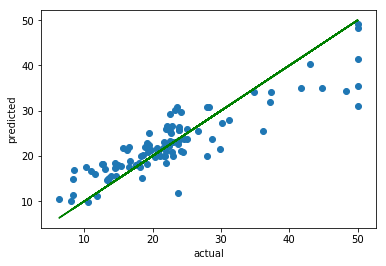

In [5]:
import matplotlib.pyplot as plt
plt.plot(y_test, y_test, color = "green")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(y_test, y_pred)
plt.show()

We perform another test using the California Housing dataset. First we load said dataset, and slice it up to convert it to a 5000 sized dataset, since the original dataset is quite large for COBRAs capabilities.

In [6]:
N = 1000
data = fetch_california_housing(return_X_y=False)
X = data.data[:N]
y = data.target[:N]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
print(X_train.shape)

(800, 8)


And fit COBRA again. This time we work with a K-Neighbors Regressor and Lasso.

In [9]:
estimator_generators = []

seed(0)


def generator(X, y):
    knr = KNeighborsRegressor()
    knr.fit(X, y)
    return knr
estimator_generators.append(generator)


def generator(X, y):
    lasso = LassoCV()
    lasso.fit(X, y)
    return lasso
estimator_generators.append(generator)

cobra = COBRA_Ensemble(estimator_generators = estimator_generators)
cobra.set_epsilon(X_train, y_train, verbose = 1)
cobra.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.8s


Best epsilon: 0.425075966


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.0s finished


In [10]:
 y_pred = cobra.diagnostics(X_test, y_test)

Estimator #0: MSE = 0.921901108, R2 = -0.124181394
Estimator #1: MSE = 0.341271334, R2 = 0.583848115
COBRA MSE = 0.331917136, R2 = 0.595254777


Here we see that although one learner is extremely weak (K-Neighbors), the improved performance of the Lasso is being used. Moreover, even the weak performance of the K-Neighbors has been used to improve over Lasso. This shows the effectiveness of the COBRA strategy.

As is noted and proved in the paper [1], the most important benefit of COBRA is that it will always try to perform approximately as good as the best learner, **without prior knowledge of which estimator is the best**. This is an extremely useful feature in practice.

We finish by plotting the predicted values.

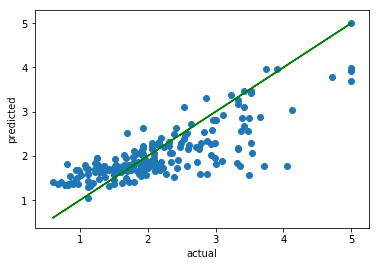

In [11]:
import matplotlib.pyplot as plt
plt.plot(y_test, y_test, color = "green")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(y_test, y_pred)
plt.show()